In [ ]:
# default_exp system_response

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
# Makes it possible to do symbolic maths and use a control system lib
import sympy
sympy.init_printing()

# Let's also ignore some warnings here due to sympy using an old matplotlib function to render Latex equations.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#hide
%matplotlib inline

# System Response

This notebook analyses how different systems might respond to different classes of inputs.

- Dominal pole approximation
- First and second order systems
- System response and performance requirements

-----------------------

## First and second order systems, and the dominant pole approximation

Lower order (1st and 2nd) are well understood and easy to characterize (speed of system, oscillations, damping...), but his is much more difficult with higher order systems.

One way to make many such systems easier to think about is to approximate the system by a lower order system using a technique called the dominant pole approximation. This approximation assumes that the slowest part of the system dominates the response, and that the faster part(s) of the system can be ignored.


**Notes:**
- In a transfer function representation, the *order* is the highest exponent in the transfer function. In a proper system, the system order is defined as the degree of the denominator polynomial. 
-  A *proper system* is a system where the degree of the denominator is larger than or equal to the degree of the numerator polynomial.
- A *strictly proper* system is a system where the degree of the denominator polynomial is larger than the degree of the numerator polynomial.

Let's take some examples and verify how a few systems behaves.

We will use Sympy to do it, so we need to define some variables first.

In [ ]:
t, K, tau = sympy.symbols('t, K, tau',real=True, positive=True)
s = sympy.Symbol('s')
u = sympy.Heaviside(t) # step function

def L(f):
    return sympy.laplace_transform(f, t, s, noconds=True)
def invL(F):
    return sympy.inverse_laplace_transform(F, s, t)

In [ ]:
def evaluate(f, times):
    res = []
    for time in times:        
        res.append(f.evalf(subs={t:time}).n(chop=1e-5))
    return res

**Side note:**

`chop` makes it possible to round float numbers off to a desired precision. Below is an example

In [ ]:
q1 = (-1.53283653303955 + 6.08703605256546e-17*sympy.I)
q2 = (-1.53283653303955 + 6.08703605256546e-5*sympy.I)

print('q1:', q1.n(chop=1e-5))
print('q2:', q2.n(chop=1e-5))

q1: -1.53283653303955
q2: -1.53283653303955 + 6.08703605256546e-5*I


### Dominant Poles

- When we have a BIBO stable system, every mode of the system is an exponentially dumped signal.
- Beyond the initial transient, the main effect is driven by the slowest modes

For example let's consider these poles:

$$
p_1 = -0.1
$$

$$
p_{2,3} = -10 \pm 17.32j
$$

$$
p_4 = -15.5
$$

$$
p_{5,6} = -20 \pm 34.64j
$$

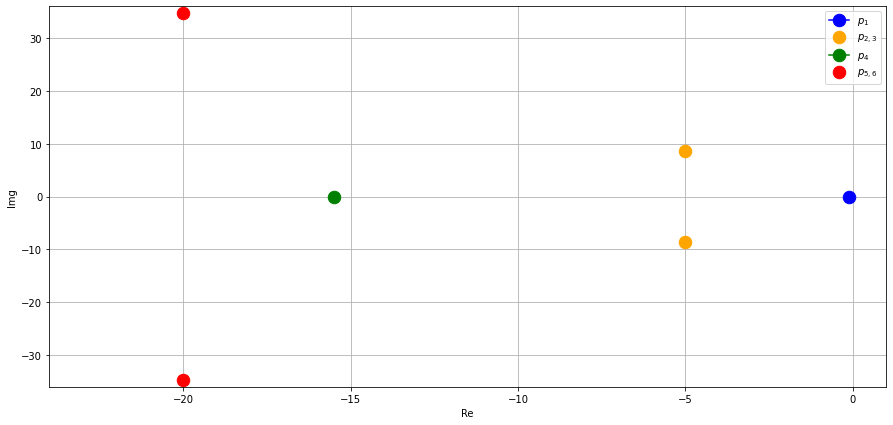

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,7))


plt.plot(-0.1,    0,                  marker='.', markersize=25, color='blue')
plt.plot([-5, -5],   [-8.66, 8.66],   marker='.', markersize=25, linestyle='', color='orange')
plt.plot(-15.5,   0,                  marker='.', markersize=25, color='green')
plt.plot([-20, -20], [-34.64, 34.64], marker='.', markersize=25, linestyle='', color='red')


axs.set_xlim([-24, 1])
axs.set_ylim([-36, 36])
axs.set_xlabel('Re')
axs.set_ylabel('Img')

plt.legend(['$p_1$', '$p_{2,3}$', '$p_4$', '$p_{5,6}$'])
plt.grid()


We can now verify what output is associated to each of these poles.

To do this we define four systems that have poles at the positions depicted above:

$$ G_1(s) = \frac{1}{(s + 0.1)} $$

$$ G_2(s) = \frac{100}{(s^2 + 10s + 100)} $$

$$ G_3(s) = \frac{15.5}{(s + 15.5)} $$

$$ G_2(s) = \frac{1600}{(s^2 + 40s + 1600)} $$



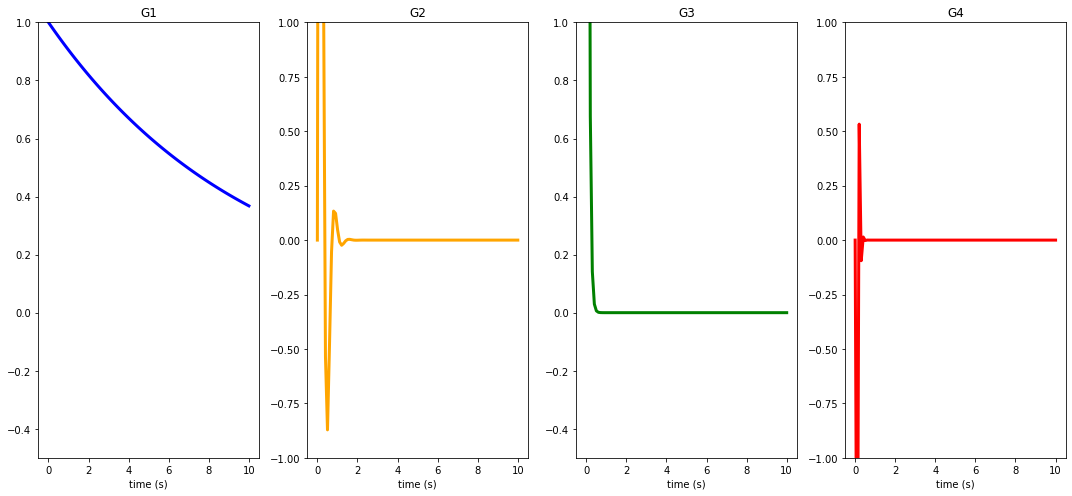

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(15,7))

time = np.linspace(0,10,100)

# Define our systems
G1 = 1/(s + 0.1)

zeta, w_n = 0.5, 10
G2 = w_n**2/(s**2 + 2*zeta*w_n*s + w_n**2)

G3 = 15.5/(s + 15.5)

zeta, w_n = 0.5, 40
G4 = w_n**2/(s**2 + 2*zeta*w_n*s + w_n**2)

# plot them
axs[0].plot(time, evaluate(invL(G1), time), color='blue',   linewidth=3), axs[0].set_ylim(-.5, 1), axs[0].set_title('G1'), axs[0].set_xlabel('time (s)')
axs[1].plot(time, evaluate(invL(G2), time), color='orange', linewidth=3), axs[1].set_ylim(-1, 1), axs[1].set_title('G2'), axs[1].set_xlabel('time (s)')
axs[2].plot(time, evaluate(invL(G3), time), color='green',  linewidth=3), axs[2].set_ylim(-.5, 1), axs[2].set_title('G3'), axs[2].set_xlabel('time (s)')
axs[3].plot(time, evaluate(invL(G4), time), color='red',    linewidth=3), axs[3].set_ylim(-1, 1), axs[3].set_title('G4'), axs[3].set_xlabel('time (s)')

fig.tight_layout()

In [ ]:
invL(G2)

- Depending on how far they are in the $s$ plane their influence in time is different. 
- **Beyond the initial transient, the slower modes are those the matter**

### Reduction of a second order system to first order

Consider an overdamped second order system:

$$
G(s) = K \frac{\alpha\beta}{(s+\alpha)(s+\beta)}
$$

whose step response is:

$$
Y(s) = K \frac{\alpha\beta}{(s+\alpha)(s+\beta)}\frac{1}{s}
$$

and hence, applying partial fraction expansion:

$$
y(t) = K \bigg ( 1 - \frac{\beta e^{-\alpha t} - \alpha e^{-\beta t}}{\beta - \alpha}\bigg )
$$

If the magnitude of $\beta$ is large compared to $\alpha$ (typically if $\beta/\alpha > 5$), and assuming $s$ is sufficiently small compared to $\beta$, we can write the following approximation for the transfer function (and as well as an approximation for the step response):

$$
G(s) \approx K \frac{\alpha\beta}{(s+\alpha)(\beta)}
$$

at which corresponds the following step response:

$$
y(t) \approx K \bigg ( 1 - \frac{\beta e^{-\alpha t}}{\beta} \bigg ) = K(1-e^{-\alpha t})
$$

Note that $G(0)$ is unchanged and this is necessary to ensure that the steady state value remains the same.

### Example 1, second order system

Let's now consider when we have two cascaded systems:

$$ G_1 = \frac{0.1}{(s+0.1)} $$

$$ G_2 = \frac{1}{(s+1)} $$

In [ ]:
G1 = 0.1/(s+0.1)

G2 = 1/(s+1)

In this case, one pole is 10 times bigger than the other. 

The entire system is then

$$ G(s) = G_1(s)G_2(s) = \frac{0.1}{(s+0.1)(s+1)} $$

In [ ]:
G = G1*G2
print(G)

0.1/((s + 0.1)*(s + 1))


And now we can plot their output:

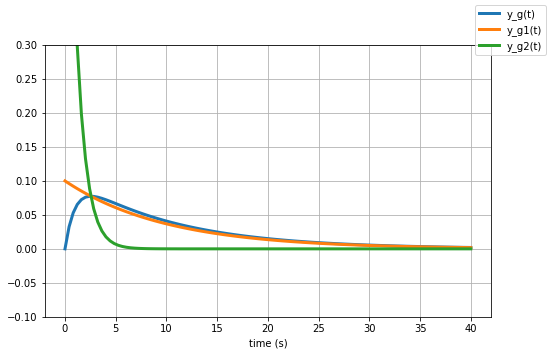

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

time = np.linspace(0,40,100)

ax.plot(time, evaluate(invL(G), time), linewidth=3)
ax.plot(time, evaluate(invL(G1), time), linewidth=3)
ax.plot(time, evaluate(invL(G2), time), linewidth=3)

ax.set_ylim(-.1, 0.3)
ax.set_xlabel('time (s)')
ax.grid()
fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

And we can also calculate the step response:

$$
Y(s)= G(s) U(s) = G(s)\frac{1}{s}
$$


And this is the output of our system when we have a step input:

<table style='margin: 0 auto' rules=none>
    <tr>
    <td> <img src="img/step-response-placeholder.png" alt="step-response-placeholder" style="width: 500px;"/> </td>
    </tr>
</table>

In [ ]:
# We can plot the figure above running this cell. Unfortunately, github CI throws an error and I still need to figure out why.

# fig, ax = plt.subplots(1,1,figsize=(8,5))

# time = np.linspace(0,40,100)

# ax.plot(time, evaluate(invL(G*1/s), time), linewidth=3)
# ax.plot(time, evaluate(invL(G1*1/s), time), linewidth=3)
# ax.plot(time, evaluate(invL(G2*1/s), time), linewidth=3)

# ax.set_ylim(-.1, 1.1)
# ax.set_xlabel('time (s)')
# ax.grid()
# fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

- The step response plot shows three plots: the blue plot is the exact response, the orange plot is the approximation assuming the pole at -0.1 dominates; the green plot is the approximation assuming that the pole at 1 dominates (which clearly it doesn't because the plot is nowhere near the exact response)

- Note that the blue and orange plots are very close to each other, so the dominant pole approximation is a good one.

- The exact response has two exponentials, a fast one with a relatively short time constant of $\tau_1 = 1/(p_1)$ and a much slower exponential with time constant $\tau_2 = 1/(p_2)$. 

- If we look at the overall resonse, the fast exponential comes to equilibrium much more quickly than the slow explonential. From the perspective of the overall response, the faster exponential comes to equilibrium (i.e., has decayed to zero) instantaneously compared to the slower exponential.

- Therefore, the slower response (due to the pole closer to the origin — at s=-0.1) _dominates_.

The second order system $G(s)$ behaves approximately like $G_1(s)$ which is the one with the slower dynamics: $$G(s) = \frac{0.1}{(s+0.1)(s+1)} \approx \frac{0.1}{(s+0.1)}$$

### Example 2, Second order, Pole dominates but not as strongly

Let's now consider a different case and build an overall system composing the following two systems in cascade:

$$
G_1(s) = \frac{0.2}{s+0.2}
$$

$$
G_2(s) = \frac{1}{s+1}
$$



In this case, one pole is only 5 times bigger than the other. 

The entire system is then

$$ G(s) = G_1(s)G_2(s) = \frac{0.2}{(s+0.2)(s+1)} $$

In [ ]:
G1 = 0.2/(s+0.2)
G2 = 1/(s+1)
G=G1*G2
print('G:', G)

G: 0.2/((s + 0.2)*(s + 1))


If we now evaluate the step response for this system:

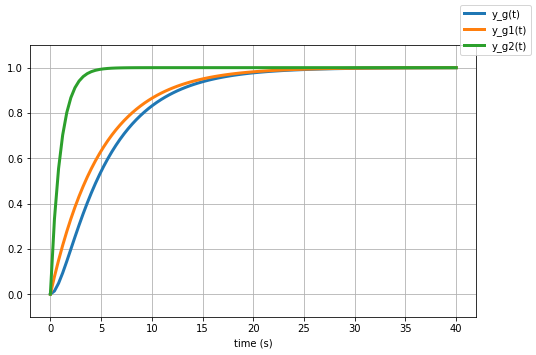

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

time = np.linspace(0,40,100)

ax.plot(time, evaluate(invL(G*1/s), time), linewidth=3)
ax.plot(time, evaluate(invL(G1*1/s), time), linewidth=3)
ax.plot(time, evaluate(invL(G2*1/s), time), linewidth=3)

ax.set_ylim(-.1, 1.1)
ax.set_xlabel('time (s)')
ax.grid()
fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

The approximation is still fairly good, but not not quite as good as when $p_1=0.1$, as we would expect.

## Example 3, Second Order, neither pole dominates

If we instead have two poles quite close to each other (note that it is their relative location - or ratio of the pole locations - that is of interest to determine if the dominant approximation is applicable).

Let's consider:

$$
G_1(s) = \frac{1.25}{s+1.25}
$$

$$
G_2(s) = \frac{1}{s+1}
$$

and the final system is:

$$
G(s) = G_1(s)G_2(s) = \frac{1.25}{(s+1)(s+1.25)}
$$

In [ ]:
G1 = 1.25/(s+1.25)
G2 = 1/(s+1)
G = G1*G2
print('G:', G)

G: 1.25/((s + 1)*(s + 1.25))


If we now calculate and plot the step response:

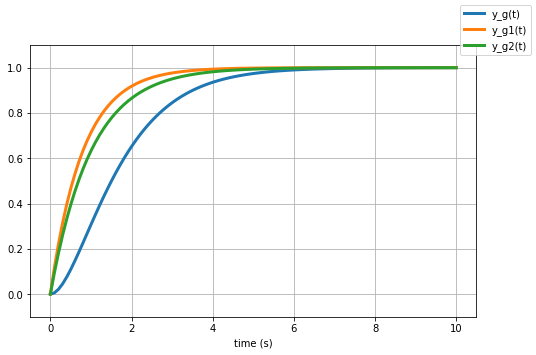

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

time = np.linspace(0,10,100)

ax.plot(time, evaluate(invL(G*1/s), time), linewidth=3)
ax.plot(time, evaluate(invL(G1*1/s), time), linewidth=3)
ax.plot(time, evaluate(invL(G2*1/s), time), linewidth=3)

ax.set_ylim(-.1, 1.1)
ax.set_xlabel('time (s)')
ax.grid()
fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

In this case, the two poles are very close to each other and the dominat pole approximation cannot be applied.

The three plots above are different: the blue (exact) response is not at all close the approximation of the approximation in which a first order pole dominates (orange or green).

Note that the step response for this case has a different time scale than the other two.

### Simplifying Higher Order Systems

The dominant pole approximation can also be applied to higher order systems. Here we consider a third order system with one real root, and a pair of complex conjugate roots.

<table style='margin: 0 auto' rules=none>
    <tr>
    <td> <img src="img/25.3rd-order-dominant-poles.png" alt="25.3rd-order-dominant-poles" style="width: 600px;"/> </td>        
    </tr>
</table>

- In this case the test for the dominant pole compare $\alpha$ against $\zeta \omega_0$ 
    - Note: sometimes  $\zeta \omega_0$ is also written $\xi \omega_n$ - they are the same thing
- This is because $\zeta \omega_0$ is the real part of the complex conjugate root 
- We only compare the real parts of the roots when determining dominance because it is the real part that determines how fast the response decreases.
- Note, that as with the previous case, the steady state gain $H(0)$ of the exact system and the two approximate systems are equal. This is necessary to ensure that the final value of the step response (which is determined by $H(0)$ is unchanged).

## Example 5, Third order, Real Pole Dominates

Let's now consider the following system

$$G(s) = \frac{\alpha \omega_n^2}{(s+\alpha)(s^2+2\xi\omega_n s + \omega_n^2)} = \frac{17}{(s+0.1)(s^2+2s+17)}$$

$$ \approx G_dp(s) = \frac{\alpha}{s+\alpha} = \frac{0.1}{s+0.1}$$

The second order poles are at $s=-1 \pm j4$ ($\xi$=0.24 and $\omega_n=\sqrt{17}$=4.1) and the real pole is at $s = -\alpha = -0.1$.

As before we write the entire system as a cascade of two systems 

$$
G_1(s)=\frac{\alpha}{s + \alpha}
$$

and

$$
G_2(s)=\frac{\omega_n^2}{s^2+2\xi\omega_n s + \omega_n^2)}
$$

with 

$$
G(s) = G_1(s)G_2(s)
$$

In [ ]:
alpha = 0.1 # real pole that dominates

In [ ]:
G1 = 0.1/(s+0.1)
G2 = 17/(s**2+2*s+17)

G = G1*G2
print('G:', G)

G: 1.7/((s + 0.1)*(s**2 + 2*s + 17))


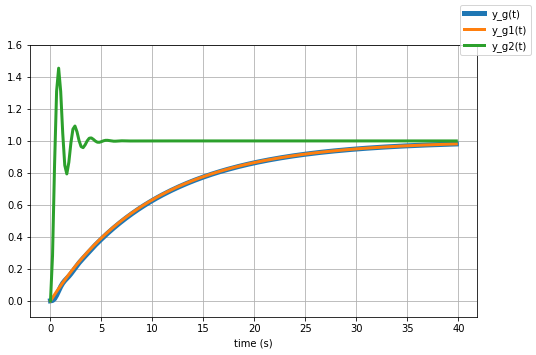

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

time = np.arange(0,40,0.2)

#ax.plot(time, evaluate(invL(G*1/s), time), linewidth=5) # this is commented out only because github CI failes. The response of G matches up the reponse of G1.
ax.plot(time, evaluate(invL(G1*1/s), time), linewidth=3)
ax.plot(time, evaluate(invL(G2*1/s), time), linewidth=3)

ax.set_ylim(-.1, 1.6)
ax.set_xlabel('time (s)')
ax.grid()
fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

- The blue (exact) and orange (due to pole at $s=-\alpha=-0.1$) lines are very close since that is the pole that dominates in this example. 
- The green line (corresponding to $G_2(s)$, and that would correspond to the case where the second order poles are assumed to dominate) is obviously a bad approximation and not useful, as expected.

**Dominant pole approximation can simplify systems analysis**


The dominant pole approximation is a method for approximating a (more complicated) high order system with a (simpler) system of lower order if the location of the real part of some of the system poles are sufficiently close to the origin compared to the other poles.

Let's consider another example:
$$
G1 = \frac{150.5}{s+150.5}
$$

with pole at -150.5

$$
G2 = \frac{100}{s^2 + 10s +100}
$$

with poles at: $p = -5 \pm 8.66j$

In [ ]:
G1 = 150.5/(s + 150.5)
print('G1: ', G1)

zeta, w_n = 0.5, 10
G2 = w_n**2/(s**2 + 2*zeta*w_n*s + w_n**2)
print('G2: ', G2)

G = G1*G2
print('G: ', G)

G1:  150.5/(s + 150.5)
G2:  100/(s**2 + 10.0*s + 100)
G:  15050.0/((s + 150.5)*(s**2 + 10.0*s + 100))


The step response is:

<table style='margin: 0 auto' rules=none>
    <tr>
    <td> <img src="img/Dominant-pole-approximation.png" alt="Dominant-pole-approximation" style="width: 600px;"/> </td>        
    </tr>
</table>

We can obtain the figure above uncommenting and running the cell below.

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(8,5))

# time = np.arange(0, 4, 0.05)

# ax.plot(time, evaluate(invL(G*1/s), time),  linewidth=7, color = 'blue')
# ax.plot(time, evaluate(invL(G1*1/s), time), linewidth=4, color = 'orange')
# ax.plot(time, evaluate(invL(G2*1/s), time), linewidth=3, color = 'green')

# ax.set_ylim(-.1, 1.6)
# ax.set_xlabel('time (s)')
# ax.grid()
# fig.legend(['y_g(t)', 'y_g1(t)', 'y_g2(t)']);

--------------------

## First-order and second-order systems

- Given that the main effect is driven by the slowest modes, then the dynamics of the system can be approximated by the modes associated to the dominant poles
- Typically this ends up being a first-order system (real dominant pole) or a second-oder system (complex-conjugated poles), possibly with a constant delay
- It is hence important to understand the response of the first-order and second-order systems as they can be representive of a broader class.

### Step response of first order systems

Given a system: 
$$G(s) = \frac{1}{s+p} = \frac{\tau}{1+\tau s}$$

with pole in $s = -p = \frac{-1}{\tau} $

and given a input: $$u(t) = 1(t)$$ 

the output of the system is:
$$ y(t) = 1 - e^{-\frac{t}{\tau}}$$

This is obtained:

$$\frac{1}{1+\tau s}\frac{1}{s} = \frac{1/\tau}{s + 1/\tau} \frac{1}{s} = \frac{A}{s + 1/\tau} + \frac{B}{s}$$

where $A = -1$, $B = 1$

We can also verify it with Sympy:

In [ ]:
F = 1/(K*s + 1)*1/s
invL(F)

We can then plot the output $y(t)$ for a particular value of the time constant $\tau=2$:

In [ ]:
time = np.linspace(0,20,100)

tau = 2 # define the time constant

y_t = 1 - np.exp(-time/tau)

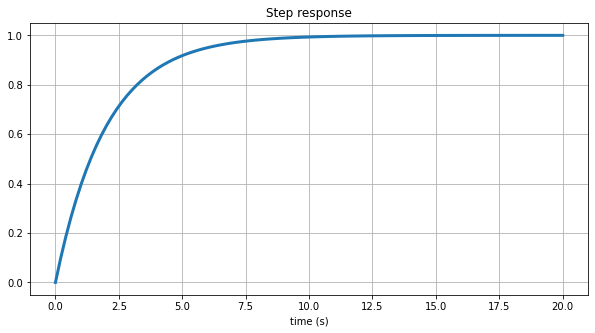

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.plot(time, y_t, linewidth=3)
plt.title('Step response')
plt.xlabel('time (s)')
plt.grid()

We call:

- $\tau$: time constant - Characterises completely the response of a first order system
- Settling time: the time it takes to get to 95% (or other times 90%, 98%) of the steady state value $y(t)=1$:
    - $t_s = -\tau ln(0.05)$
    - This is because:
       $$
       y(t) = 1 - e^{-\frac{t}{\tau}} \Rightarrow 1 - y(t) = e^{-\frac{t}{\tau}} \Rightarrow \ln(1-y(t)) = -\frac{t}{\tau}, \;\; \text{when} \;\; y(t)=0.95 \Rightarrow t = -\tau ln(0.05)
       $$

In [ ]:
#y_t = -1 # Desired steady state value
final_value_pc = 0.95 # percentage of y_t

# final_value = 1 - np.exp(-t/tau)
# np.log(1-final_value) = -t/tau

t_s = -tau*np.log(1-final_value_pc)

print('Time to get to {}% of final value {:.1f}: {:.2f}s'.format(final_value_pc, y_t[-1], t_s))

Time to get to 0.95% of final value 1.0: 5.99s


Note that, after $\tau$ seconds, the system gets to the $64\%$ of the final value

### To recap

- We have defined two times in the response of a first order system:
  - Settling time $t_s$: time to get to 0.95\% of the final value
  - Time constant $\tau$, which is the time to get to the 64\% of the final value.
  
We can plot them, together with the step response of the system:

$$ y(t) = 1 - e^{-\frac{t}{\tau}}$$

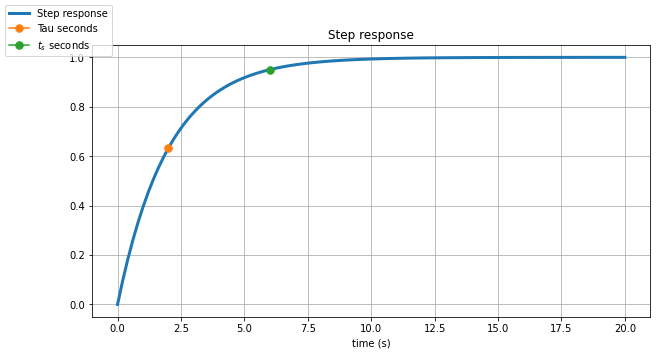

In [ ]:
fig = plt.figure(figsize=(10,5))

# step response
plt.plot(time, y_t, linewidth=3)  

# tau - time constant
plt.plot(tau, 1 - np.exp(-tau/tau), marker='.', markersize=15)

# settling time
plt.plot(t_s, final_value_pc*y_t[-1], marker='.', markersize=15)


fig.legend(['Step response', 'Tau seconds', '$t_s$ seconds'], loc='upper left')
plt.title('Step response')
plt.xlabel('time (s)')
plt.grid()

------------------------------------------

### Step response of second order systems

Given a system: 
$$G(s) = \frac{1}{\frac{s^2}{w_n^2} + \frac{2\xi}{w_n}s + 1}$$

with $ 0 < \xi < 1 $ 

- $\xi$ is called damping ratio
- $\omega_n$ (sometime also called $\omega_0$) is the natural frequency of the system.

The system has two conjugate-complex poles:

 $$s = -\xi w_n \pm j \sqrt{1-\xi^2} $$
 

As before, we can calculate the step reponse:

- input $$u(t)=1(t)$$
- output $$y(t) = 1 - \frac{1}{\sqrt{1-\xi^2}} e^{-\xi w_n t} sin( w_n\sqrt{1-\xi^2}t + arccos(\xi))$$

_Note: Proving this is a useful exercise_

As before we can plot it.

We will do it for a set of damping ratios: $\xi = [0.1, 0.25, 0.5, 0.7]$ and for a fixed value of $\omega_n=1$.

In [ ]:
xis = [0.1, 0.25, 0.5, 0.7] # damping ratios
wn = 1 # natural frequency.

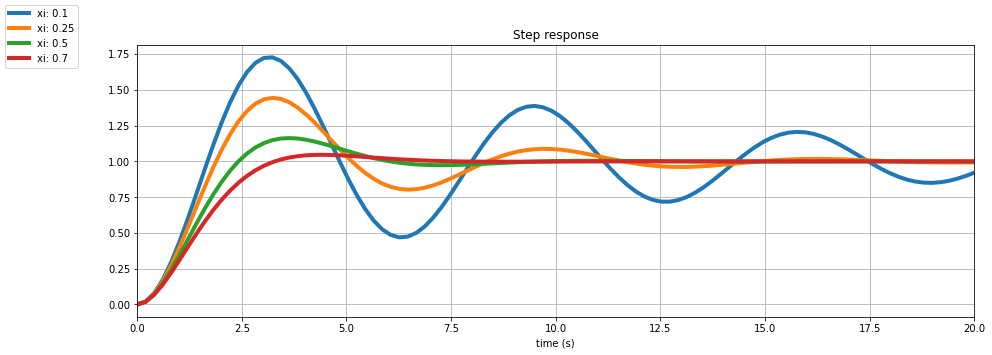

In [ ]:
fig = plt.figure(figsize=(15,5))
legend_strs = []
for xi in xis:
    y_t = 1 - (1/np.sqrt(1-xi**2)) * np.exp(-xi*wn*time) * np.sin(wn*np.sqrt(1-xi**2)*time+np.arccos(xi))
    plt.plot(time, y_t, linewidth=4)


# this part is to have a legend
for xi in xis:
    legend_strs.append('xi: ' + str(xi))

fig.legend(legend_strs, loc='upper left')

plt.xlim(0, 20)
plt.title('Step response')
plt.xlabel('time (s)')
plt.grid()

There are a few notable points that we can identify for the response of a second order system:

- Maximum overshoot: $$ S \% = 100 e^{\Large -\frac{\xi\pi}{\sqrt{1-\xi^2}}} $$

- Time of Maximum overshoot: $$t_{max} = \frac{\pi}{w_n\sqrt{1-\xi^2}} $$

- Settling time (within a desired interval, e.g., 5%): $$t_{s} \approx -\frac{1}{\xi w_n}ln(0.05) $$

- Oscillation period: $$T_{P} = \frac{2\pi}{w_n\sqrt{1-\xi^2}} $$

Let's see where they are on the plot for one specific choise of $\xi=0.2$ and $\omega_n=1$.

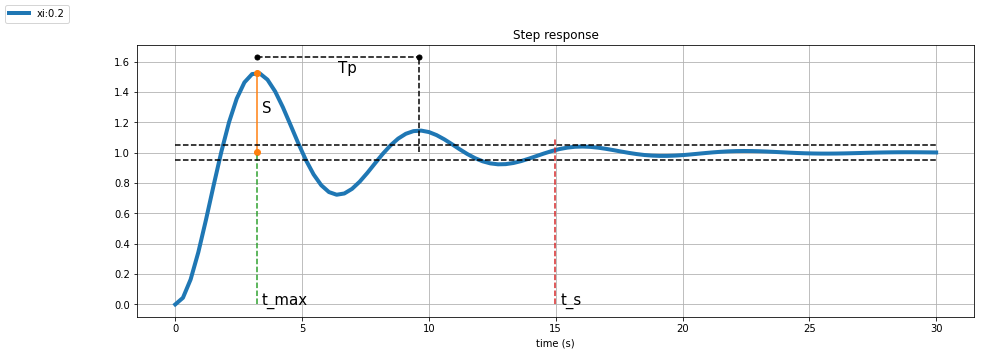

In [ ]:
xi = 0.2
wn = 1

# Maximum overshoot
S = np.exp(-xi*3.14/(np.sqrt(1-xi**2)))
# Time of maximum overshoot
t_max = 3.14/(wn*np.sqrt(1-xi**2))
# Settling time within 5%
t_s = -1/(xi*wn)*np.log(0.05)
# Period of the oscillations
Tp = 2*3.14/(wn*np.sqrt(1-xi**2))

# time vector
time = np.linspace(0,30,100)

# create the figure
fig = plt.figure(figsize=(15,5))

# overall response y(t)
y_t = 1 - (1/np.sqrt(1-xi**2)) * np.exp(-xi*wn*time) * np.sin(wn*np.sqrt(1-xi**2)*time+np.arccos(xi))
plt.plot(time, y_t, linewidth=4)

# maximum overshoot
plt.plot([t_max, t_max], [y_t[-1], y_t[-1]+S], marker='.', markersize=12)
plt.text(t_max+0.2, y_t[-1]+S/2, 'S', fontsize=15) # text box

# Time of maximum overshoot
plt.plot([t_max, t_max], [0, 1], markersize=12, linestyle='--')
plt.text(t_max+0.2, 0.0, 't_max', fontsize=15) # text box

# Let's also plot +-0.05 boundary lines around y(t)
plt.plot([0, time[-1]], [1-0.05, 1-0.05], linestyle='--', color='k')
plt.plot([0, time[-1]], [1+0.05, 1+0.05], linestyle='--', color='k')

# Settling time within a desired +-0.05 interval
plt.plot([t_s, t_s], [0, 1.1], linestyle='--')
plt.text(t_s+0.2, 0.0, 't_s', fontsize=15) # textbox

# Oscillation period (this is only to show it on the plot)
plt.plot([t_max, t_max+Tp], [y_t[-1]+S+0.1, y_t[-1]+S+0.1], marker='.', linestyle='--', color='k', markersize=10)
plt.plot([t_max+Tp, t_max+Tp], [y_t[-1], y_t[-1]+S+0.1], linestyle='--', color='k')
plt.text((t_max+t_max+Tp)/2, y_t[-1]+S, 'Tp', fontsize=15)

fig.legend(['xi:{:.1f}'.format(xi)], loc='upper left')

plt.title('Step response')
plt.xlabel('time (s)')
plt.grid()

---------------------